<a href="https://colab.research.google.com/github/Norawit29/RandomizationProject/blob/main/simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import requests
import hashlib
from datetime import datetime, timedelta, timezone
from typing import List, Dict, Any

NIST_BEACON_URL = "https://beacon.nist.gov/beacon/2.0/pulse/time/{}"

def fetch_nist_beacon(start_date_string: str, end_date_string: str) -> List[str]:
    """
    Fetches NIST beacon values for each day in the specified range.

    Parameters:
        start_date_string: The start date string in YYYY-MM-DD format.
        end_date_string: The end date string in YYYY-MM-DD format.

    Returns:
        A list of output values from the NIST beacon for each day in the range.

    Raises:
        ValueError: If the input date format is incorrect.
        ConnectionError: If there's an issue fetching the beacon.
    """
    start_date = datetime.strptime(start_date_string, "%Y-%m-%d").replace(tzinfo=timezone.utc)
    end_date = datetime.strptime(end_date_string, "%Y-%m-%d").replace(tzinfo=timezone.utc)

    output_values = []

    current_date = start_date
    while current_date <= end_date:
        utc_timestamp_ms = int(current_date.timestamp() * 1000)

        try:
            response = requests.get(NIST_BEACON_URL.format(utc_timestamp_ms))
            response.raise_for_status()
            data = response.json()
            output_values.append(data['pulse']['outputValue'])
        except requests.HTTPError as http_err:
            raise ConnectionError(f'HTTP error occurred: {http_err}') from None
        except requests.ConnectionError as conn_err:
            raise ConnectionError(f'Connection error occurred: {conn_err}') from None
        except requests.Timeout as timeout_err:
            raise ConnectionError(f'Timeout error occurred: {timeout_err}') from None
        except KeyError as key_err:
            raise ValueError('Unexpected response format from NIST beacon.') from key_err

        current_date += timedelta(days=1)

    return output_values


def sha3_512_hash_list(input_strings: List[str]) -> List[str]:
    """
    Hashes the input strings with SHA3-512 and returns the values.

    Parameters:
        input_strings: The strings to be hashed.

    Returns:
        The hexadecimal representations of the hashes.
    """
    hash_values = [hashlib.sha3_512(s.encode()).hexdigest() for s in input_strings]

    return hash_values


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from typing import List, Tuple
import seaborn as sns

def calculate_position_distribution(beacon_values: List[str], observed_data: List[str]) -> np.ndarray:
    """
    Calculates the position distribution of hashed IDs using beacon values.

    Parameters:
        beacon_values: List of beacon values used for hashing.
        observed_data: List of participant IDs.

    Returns:
        A 2D numpy array representing the position distribution.
    """
    original_id_to_position = {id_: idx for idx, id_ in enumerate(observed_data)}
    position_distribution = np.zeros((len(observed_data), len(observed_data)))

    for beacon_value in beacon_values:
      # Append beacon value to each participant ID and hash
       hashed_ids = sha3_512_hash_list([str(id_) + beacon_value for id_ in observed_data])

      # Sort the hash values in lexicographic order
       hashed_ids_sort = hashed_ids.copy()
       hashed_ids_sort.sort()
      # random.shuffle(hashed_ids_sort)

       for position, hashed_id in enumerate(hashed_ids_sort):
          original_id_index = original_id_to_position[observed_data[hashed_ids.index(hashed_id)]]
          position_distribution[original_id_index, position] += 1

    return position_distribution


def plot_position_distribution(position_distribution: np.ndarray, observed_data: List[str]):
    """
    Plots the position distribution.

    Parameters:
        position_distribution: 2D numpy array from calculate_position_distribution function.
        observed_data: List of participant IDs.
    """
    plt.figure(figsize=(8, 8))  # Adjusted to make the figure square
    plt.imshow(position_distribution, cmap='rocket', aspect='auto')
    plt.colorbar(label='Frequency')
    plt.xlabel('Order of Question')
    plt.ylabel("Question Number")
    plt.title('Position Distribution of Each Number')

    tick_labels = list(range(0, len(observed_data) + 1, 10))
    plt.xticks(tick_labels, [str(i) for i in tick_labels], rotation=45)
    plt.yticks(tick_labels, [str(i) for i in tick_labels])

    plt.tight_layout()
    plt.show()


def perform_chi_square_test(position_distribution: np.ndarray, total_values: int) -> Tuple[float, float]:
    """
    Performs a Chi-Square test on the position distribution.

    Parameters:
        position_distribution: 2D numpy array from calculate_position_distribution function.
        total_values: Total number of values or trials in the Chi-Square test.

    Returns:
        A tuple of Chi-Square statistic and P-value.
    """
    expected_frequency_per_position = total_values / position_distribution.shape[0]
    expected_frequencies = np.full(position_distribution.shape, expected_frequency_per_position)
    chi2_stat, p_val = chisquare(position_distribution.ravel(), f_exp=expected_frequencies.ravel())

    return chi2_stat, p_val


Total number of beacon values: 365


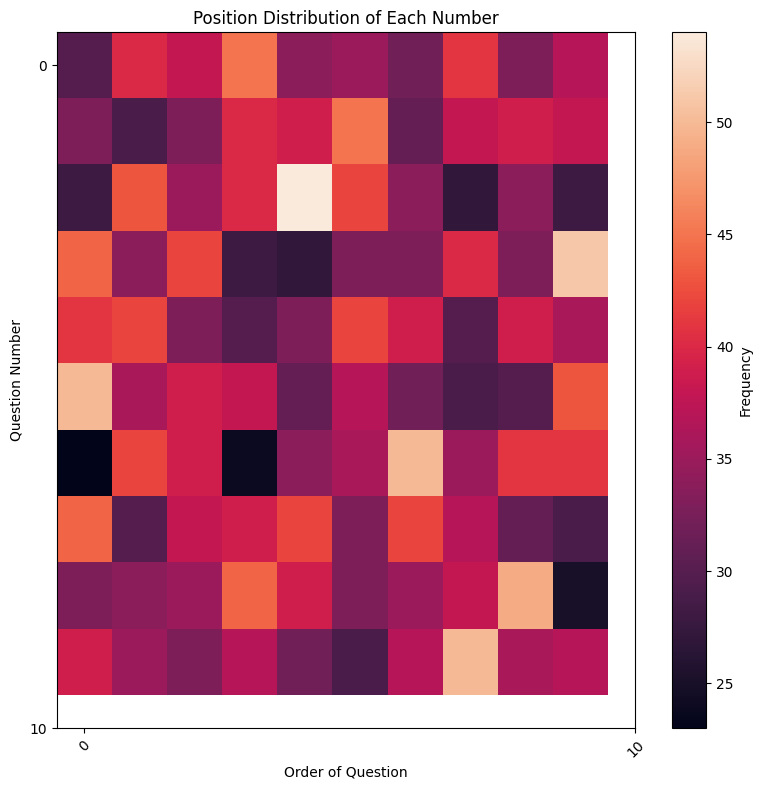

Chi-Square Statistic: 100.95890410958903
P-value: 0.4263679361001118


In [ ]:
# Use of functions for each distinct step in the process

# Fetch beacon values from 2022-11-01 to 2023-10-31
beacon_values = fetch_nist_beacon(start_date_string="2022-11-01", end_date_string="2023-10-31")
print(f"Total number of beacon values: {len(beacon_values)}")

# Observed data, such as Question IDs
observed_data = [str(i) for i in range(10)]

# Calculate the position distribution
position_distribution = calculate_position_distribution(beacon_values, observed_data)

# Plot the position distribution
plot_position_distribution(position_distribution, observed_data)

# Perform the Chi-Square test and print the results
chi2_stat, p_val = perform_chi_square_test(position_distribution, len(beacon_values))
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_val}")
